# 3. Creating Muscle-driven Simulations with OpenSim Moco


## 3.1. Objectives

[OpenSim Moco](https://opensim-org.github.io/opensim-moco-site/) is a software package for creating musculoskeletal simulations using trajectory optimization [[1]](https://doi.org/10.1371/journal.pcbi.1008493). Users define problems by providing an OpenSim model, cost function terms, and additional problem constraints via an easy-to-use scripting interface. Moco employs the state-of-the-art direct collocation method to rapidly solve trajectory optimization problems.

**Purpose**

The purpose of this tutorial is to introduce users to Moco via the [Conda OpenSim](https://anaconda.org/opensim-org/opensim) and [Jupyter notebooks](https://jupyter.org/). In this tutorial you will:

*   Solve a standalone "sliding mass" problem with OpenSim Moco.

## 3.2. Set up Conda and OpenSim

In the following cell, you will use [condacolab](https://github.com/conda-incubator/condacolab) to install [Miniconda](https://docs.conda.io/en/latest/miniconda.html). If you want to install a different conda distribution (e.g., Anaconda, Mambaforge) check [condacolab's documentation](https://github.com/conda-incubator/condacolab#usage).

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

Don't worry if after executing the previous cell you get an error saying that your session has failed. The reason for this is that condacolab needs to restart the session for the changes to take effect. Because of this, you have to execute the previous cell first, before executing any other cell.

Now, execute the following cell to install the OpenSim conda package using conda.

In [ ]:
!conda install opensim_admin::opensim-moco

## 3.3. Solve the "sliding mass" problem


The following cell imports the OpenSim module and, if successful, shows the current version and build date (**should be 4.5**).

In [1]:
import os
import numpy as np
import opensim as osim
osim.GetVersionAndDate()

'version 4.5-2023-11-26-efcdfd3eb, build date 23:19:12 Nov 28 2023'

In [5]:
# Create a simple model of a one-dimensional "sliding" mass.
model = osim.Model()
model.setName('sliding_mass')
model.set_gravity(osim.Vec3(0, 0, 0))
body = osim.Body('body', 2.0, osim.Vec3(0), osim.Inertia(0))
model.addComponent(body)

# Allows translation along x.
joint = osim.SliderJoint('slider', model.getGround(), body)
coord = joint.updCoordinate()
coord.setName('position')
model.addComponent(joint)

actu = osim.CoordinateActuator()
actu.setCoordinate(coord)
actu.setName('actuator')
actu.setOptimalForce(1)
model.addComponent(actu)

body.attachGeometry(osim.Sphere(0.05))

model.finalizeConnections()

# Create MocoStudy.
# ================
study = osim.MocoStudy()
study.setName('sliding_mass')

# Define the optimal control problem.
# ===================================
problem = study.updProblem()

# Model (dynamics).
# -----------------
problem.setModel(model)

# Bounds.
# -------
# Initial time must be 0, final time can be within [0, 5].
problem.setTimeBounds(osim.MocoInitialBounds(0.), osim.MocoFinalBounds(0., 5.))

# Position must be within [-5, 5] throughout the motion.
# Initial position must be 0, final position must be 1.
problem.setStateInfo('/slider/position/value', osim.MocoBounds(-5, 5),
                     osim.MocoInitialBounds(0), osim.MocoFinalBounds(1))
# Speed must be within [-50, 50] throughout the motion.
# Initial and final speed must be 0. Use compact syntax.
problem.setStateInfo('/slider/position/speed', [-50, 50], [0], [0])

# Applied force must be between -50 and 50.
problem.setControlInfo('/actuator', osim.MocoBounds(-50, 50))

# Cost.
# -----
problem.addGoal(osim.MocoFinalTimeGoal())

# Configure the solver.
# =====================
solver = study.initCasADiSolver()
solver.set_num_mesh_intervals(100)

# Now that we've finished setting up the study, print it to a file.
if not os.path.exists('sliding_mass'):
    os.mkdir('sliding_mass')
study.printToXML(os.path.join('sliding_mass', 'sliding_mass.omoco'))

# Solve the problem.
# ==================
solution = study.solve()
# study.visualize(solution)

solution.write(os.path.join('sliding_mass', 'sliding_mass_solution.sto'))

You should now have a sliding_mass_solution.sto under the directory `/sliding_mass`.

## 3.3. Fit function-based paths for the "squat-to-stand" model 

Use forward integration to create a random trajectory that we can use as a reference when fitting polynomial functions to represent muscle lengths. 

In [6]:
# Load the model and initialize the multibody system
model = osim.Model('squatToStand_3dof9musc.osim')
state = model.initSystem()

# Set an initial pose.
coordSet = model.updCoordinateSet()
coordSet.get('hip_flexion_r').setValue(state, -40 * (np.pi / 180))
coordSet.get('knee_angle_r').setValue(state, -45 * (np.pi / 180))
coordSet.get('ankle_angle_r').setValue(state, -25 * (np.pi / 180))

# Run a 0.5 second forward simulation.
manager = osim.Manager(model, state)
manager.integrate(0.5)

# Save the states to a file.
table = manager.getStatesTable()
sto = osim.STOFileAdapter()

if not os.path.exists('path_fitting'):
    os.mkdir('path_fitting')
sto.write(table, os.path.join('path_fitting', 'reference_states.sto'))

Now use `PolynomialPathFitter` to randomly sample coordinate values around the reference trajectory. First,muscle lengths and moment arms will be computed from the sampled coordinate values. Coefficients for multivariate polynomial functions representing the muscle lengths are determined using a least-squares fit. Both the muscle lengths and the moment arms (via the polynomial derivatives) are included in the fitting process. 

In [8]:
fitter = osim.PolynomialPathFitter()
fitter.setModel(osim.ModelProcessor(model))

table = osim.TimeSeriesTable(os.path.join('path_fitting', 'reference_states.sto'))
times = table.getIndependentColumn()
# TODO avoid this with the latest OpenSim API.
for i in reversed(range(len(times))):
    table.setIndependentValueAtIndex(i, i)
for i in range(len(times)):
    if i % 5 != 0:
        table.removeRow(i)
fitter.setCoordinateValues(osim.TableProcessor(table))
fitter.setMaximumPolynomialOrder(7)
fitter.setNumSamplesPerFrame(25)
fitter.setGlobalCoordinateSamplingBounds(osim.Vec2(-30, 30))
# TODO include this when the API is updated.
# fitter.setUseStepwiseRegression(True)
fitter.setPathLengthTolerance(1e-3)
fitter.setMomentArmTolerance(1e-3)
fitter.setOutputDirectory('path_fitting')
fitter.run()

Now we'll plot the results to compare the muscle lengths computed from the fitted polynomial functions to the original muscle lengths.

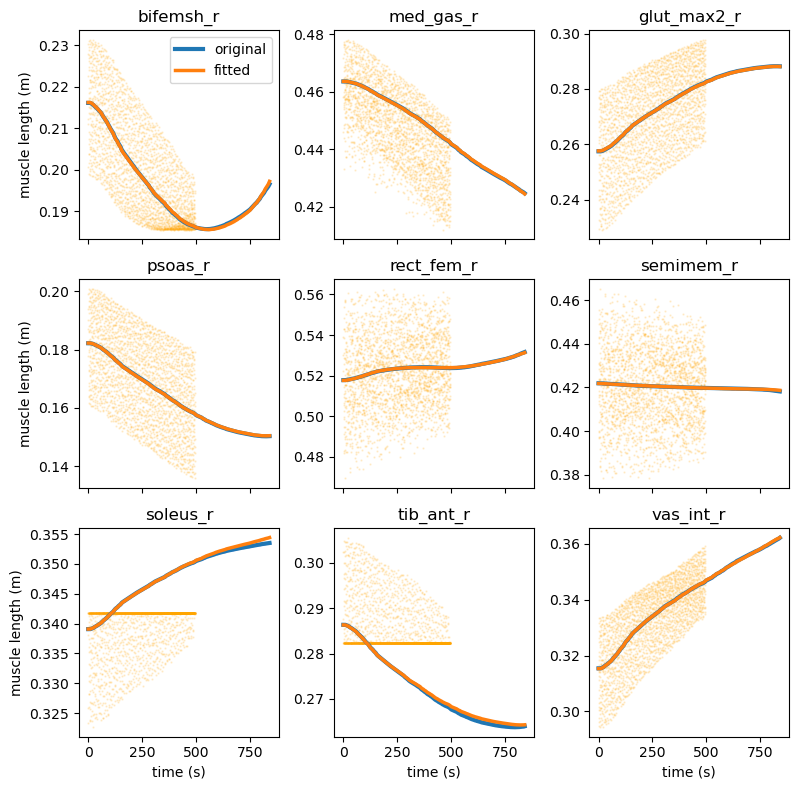

In [9]:
from matplotlib import pyplot as plt

lengths = osim.TimeSeriesTable(
    os.path.join('path_fitting', 'squatToStand_path_lengths.sto'))
lengthsFitted = osim.TimeSeriesTable(
    os.path.join('path_fitting', 'squatToStand_path_lengths_fitted.sto'))
lengthsSampled = osim.TimeSeriesTable(
    os.path.join('path_fitting', 'squatToStand_path_lengths_sampled.sto'))
lengthsSampledFitted = osim.TimeSeriesTable(
    os.path.join('path_fitting', 'squatToStand_path_lengths_sampled_fitted.sto'))

# TODO these plots will look better with the latest API fixes.
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for ilabel, label in enumerate(lengths.getColumnLabels()):
    irow = ilabel // 3
    icol = ilabel % 3
    axs[irow, icol].scatter(
        lengthsSampled.getIndependentColumn(), 
        lengthsSampled.getDependentColumn(label).to_numpy(),
        alpha=0.15, color='blue', s=0.5)
    axs[irow, icol].scatter(
        lengthsSampledFitted.getIndependentColumn(), 
        lengthsSampledFitted.getDependentColumn(label).to_numpy(),
        alpha=0.15, color='orange', s=0.5)
    axs[irow, icol].plot(
        lengths.getIndependentColumn(), 
        lengths.getDependentColumn(label), 
        label='original', lw=3)
    axs[irow, icol].plot(
        lengthsFitted.getIndependentColumn(), 
        lengthsFitted.getDependentColumn(label), 
        label='fitted', lw=2.5)
    title = label.replace('/forceset/', '').replace('_length', '')
    axs[irow, icol].set_title(title)
    if not irow and not icol:
        axs[irow, icol].legend()
    if not irow == 2:
        axs[irow, icol].set_xticklabels([])
    else:
        axs[irow, icol].set_xlabel('time (s)')
    if not icol:
        axs[irow, icol].set_ylabel('muscle length (m)')

fig.tight_layout()
plt.show()

Now that we have a good fit for our function-based muscle paths, we can move on to creating a squat-to-stand simulation with Moco.

## 3.4. Muscle-driven predictive simulation

In [10]:
# Part 1: Create a new MocoStudy.
study = osim.MocoStudy()
study.setName('squat_to_stand_prediction')

# Part 2: Initialize the problem.
problem = study.updProblem()

# Part 3: Construct a model using the function-based paths.
modelProcessor = osim.ModelProcessor('squatToStand_3dof9musc.osim')
modelProcessor.append(osim.ModOpScaleMaxIsometricForce(2.0))
modelProcessor.append(osim.ModOpReplaceMusclesWithDeGrooteFregly2016())
modelProcessor.append(osim.ModOpIgnorePassiveFiberForcesDGF())
modelProcessor.append(osim.ModOpIgnoreTendonCompliance())
modelProcessor.append(osim.ModOpScaleActiveFiberForceCurveWidthDGF(1.5))
modelProcessor.append(osim.ModOpReplacePathsWithFunctionBasedPaths(
    os.path.join('path_fitting', 'squatToStand_FunctionBasedPathSet.xml')))
model = modelProcessor.process()
problem.setModel(model)

# Part 3: Set bounds on the problem.
#
# problem.setTimeBounds(initial_bounds, final_bounds)
# problem.setStateInfo(path, trajectory_bounds, inital_bounds, final_bounds)
#
# All *_bounds arguments can be set to a range, [lower upper], or to a
# single value (equal lower and upper bounds). Empty brackets, [], indicate
# using default bounds (if they exist). You may set multiple state infos at
# once using setStateInfoPattern():
#
# problem.setStateInfoPattern(pattern, trajectory_bounds, inital_bounds, ...
#       final_bounds)
#
# This function supports regular expressions in the 'pattern' argument;
# use '.*' to match any substring of the state/control path
# For example, the following will set all coordinate value state infos:
#
# problem.setStateInfoPattern('/path/to/states/.*/value', ...)

# Time bounds
problem.setTimeBounds(0, 1)

# Position bounds: the model should start in a squat and finish 
# standing up.
problem.setStateInfo('/jointset/hip_r/hip_flexion_r/value', 
    [-2, 0.5], -2, 0)
problem.setStateInfo('/jointset/knee_r/knee_angle_r/value', 
    [-2, 0], -2, 0)
problem.setStateInfo('/jointset/ankle_r/ankle_angle_r/value', 
    [-0.5, 0.7], -0.5, 0)

# Velocity bounds: all model coordinates should start and end at rest.
problem.setStateInfoPattern('/jointset/.*/speed', [], 0, 0)

# Part 4: Add a MocoControlCost and MocoInitialActivationGoal to the problem.
problem.addGoal(osim.MocoControlGoal('myeffort'))
problem.addGoal(osim.MocoInitialActivationGoal('initial_activation'))

# Part 5: Configure the solver.
solver = study.initCasADiSolver()
solver.set_num_mesh_intervals(25)
solver.set_optim_finite_difference_scheme('forward')
solver.set_optim_convergence_tolerance(1e-4)
solver.set_optim_constraint_tolerance(1e-4)

# Part 6: Print the study to a file.
if not os.path.exists('squat_to_stand'):
    os.mkdir('squat_to_stand')
study.printToXML(os.path.join('squat_to_stand', 'squat_to_stand.xml'))

# Part 7: Solve! Write the solution to file, and visualize.
predictSolution = study.solve()
solutionFile = os.path.join('squat_to_stand', 'squat_to_stand_prediction_solution.sto')
predictSolution.write(solutionFile)
# study.visualize(predictSolution)

# Part 8: Create a PDF report of the solution.
output = os.path.join('squat_to_stand', 'squat_to_stand_prediction_report.pdf')
report = osim.report.Report(model, 
                            solutionFile,
                            output=output, 
                            bilateral=True)
report.generate()

In [ ]:
# TODO does not work in VS Code
from IPython.display import IFrame
IFrame(src='squat_to_stand_prediction_report.pdf', width=400, height=400)

## 3.5. Visualize solution with the OpenSim Viewer
TODO

## 3.6. Optimizing a passive assistive device

Optimized stiffness: 108.6 Nm/rad
Optimized rest length: -0.34 rad


ValueError: 'rowLabels' must be of length 1

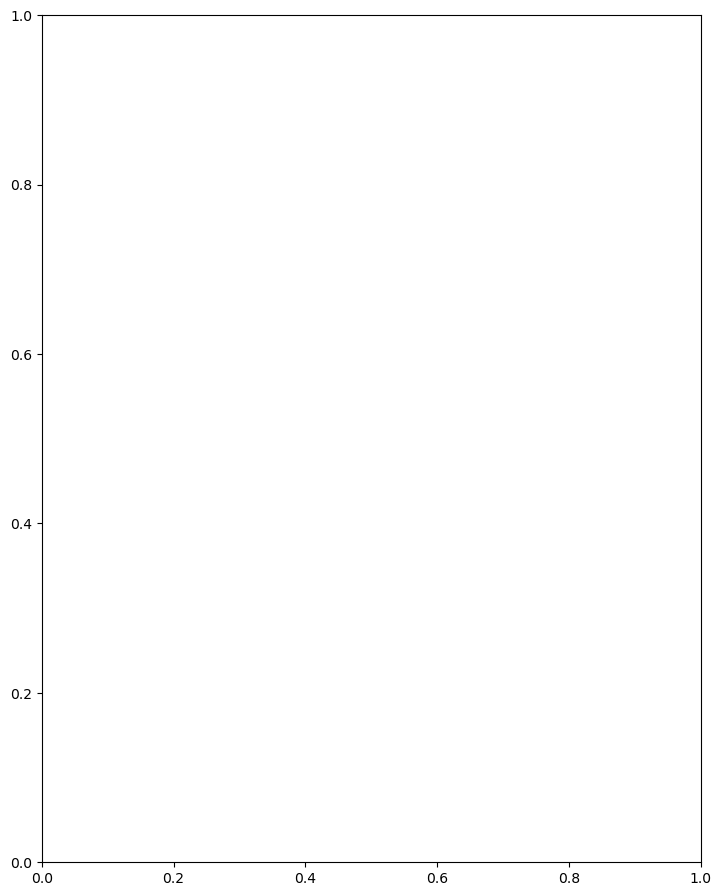

In [12]:
# Part 1: Load the base squat-to-stand MocoStudy.
study = osim.MocoStudy(os.path.join('squat_to_stand', 'squat_to_stand.xml'))
problem = study.updProblem()
solver = osim.MocoCasADiSolver.safeDownCast(study.updSolver())

# Part 2: Recreate the model, now adding a passive assistive device at the knee
modelProcessor = osim.ModelProcessor('squatToStand_3dof9musc.osim')
modelProcessor.append(osim.ModOpScaleMaxIsometricForce(2.0))
modelProcessor.append(osim.ModOpReplaceMusclesWithDeGrooteFregly2016())
modelProcessor.append(osim.ModOpIgnorePassiveFiberForcesDGF())
modelProcessor.append(osim.ModOpIgnoreTendonCompliance())
modelProcessor.append(osim.ModOpScaleActiveFiberForceCurveWidthDGF(1.5))
modelProcessor.append(osim.ModOpReplacePathsWithFunctionBasedPaths(
    os.path.join('path_fitting', 'squatToStand_FunctionBasedPathSet.xml')))
model = modelProcessor.process()

# The device is a SpringGeneralizedForce acting on the knee angle.
device = osim.SpringGeneralizedForce('knee_angle_r')
device.setName('passive_knee_device')
device.setStiffness(50)
device.setRestLength(0)
device.setViscosity(0)
model.addForce(device)

# Part 3: Update the problem with the new model.
problem.setModel(model)

# Part 4: Add MocoParameters to the problem to optimize device stiffness and 
# rest length.
stiffness = osim.MocoParameter('stiffness', '/forceset/passive_knee_device', 
        'stiffness', osim.MocoBounds(0, 400))
problem.addParameter(stiffness)

rest_length = osim.MocoParameter('rest_length', '/forceset/passive_knee_device', 
        'rest_length', osim.MocoBounds(-1, 1))
problem.addParameter(rest_length)

# Part 5: Update the solver with the new problem (i.e., new model and parameters).
solver.resetProblem(problem)

# Part 6: Set solver parameter optimization flag.
# -----------------------------------------------
# This flag tells MocoCasADiSolver that initSystem() calls on the model are unnecessary
# to optimize the parameters. Other parameters (e.g., body mass) require initSystem(), 
# since they change the model's underlying multibody system in Simbody. Since changing
# parameters in SpringGeneralizedForce does not change the multibody system, we can set 
# this flag to false to speed up the optimization.
solver.set_parameters_require_initsystem(False)

# Part 7: Solve the problem.
deviceSolution = study.solve()
if not os.path.exists('device_optimization'):
    os.mkdir('device_optimization')
solutionFile = os.path.join('device_optimization', 
    '   squat_to_stand_device_optimization_solution.sto')
deviceSolution.write(solutionFile)
# study.visualize(deviceSolution)

# Part 8: Extract the optimized parameters.
parameters = deviceSolution.getParameters().to_numpy()
print(f'Optimized stiffness: {parameters[0]:.1f} Nm/rad')
print(f'Optimized rest length: {parameters[1]:.2f} rad')

# Part 9: Create a PDF report of the solution.
output = os.path.join('device_optimization', 
        'squat_to_stand_device_optimization_report.pdf')
ref_files = []
ref_files.append(os.path.join('squat_to_stand', 
        'squat_to_stand_prediction_solution.sto'))
report = osim.report.Report(model, 
                            solutionFile,
                            output=output, 
                            ref_files=ref_files,
                            bilateral=True)
report.generate() # TODO fix issue with reports and parameters

## 3.7. Synergy-driven "squat-to-stand" motion
TODO

## 3.X. Conclusion

In this tutorial you used [condacolab](https://github.com/conda-incubator/condacolab) to install [Miniconda](https://docs.conda.io/en/latest/miniconda.html) in [Google Colab](https://colab.research.google.com/?hl=en). Then, you  installed Conda [OpenSim](https://opensim.stanford.edu/) in the Miniconda environment, and you tested it by creating and simulating a simple pendulum and simulating. Finally, you plotted the positions of the pendulum using [matplotlib](https://matplotlib.org/).

## 3.X. Useful Links

> **OpenSim Moco Website:** https://opensim-org.github.io/opensim-moco-site/
>
> **OpenSim Moco Publication:** https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008493
>
> **OpenSim SimTK Website:** https://simtk.org/projects/opensim

## 3.X Acknowledgments

Thanks to [OpenSimColab](https://simtk.org/projects/opencolab) project [[2]](https://doi.org/10.1080/10255842.2022.2104607) for creating the first OpenSim Conda package.

## 3.X. References

> [1] Dembia CL, Bianco NA, Falisse A, Hicks JL, Delp SL (2020) OpenSim Moco: Musculoskeletal optimal control. PLOS Computational Biology 16(12): e1008493. https://doi.org/10.1371/journal.pcbi.1008493
>
> [2] Mokhtarzadeh, H., Jiang, F., Zhao, S., & Malekipour, F. (2022). **OpenColab project: OpenSim in Google colaboratory to explore biomechanics on the web.** *Computer Methods in Biomechanics and Biomedical Engineering*, 1–9. https://doi.org/10.1080/10255842.2022.2104607